If you are unable to connect to a GPU runtime, connect with CPU. It may be slower but the code can handle CPU as well since we do an if-check.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

## Loading the data

We will be loading the dataset from CIFAR-10, a dataset with images of 60,000 32x32 images across 10 classes:  
(ship, bird, frog, truck, automobile, deer, cat, dog, horse, airplane)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("My device is", device)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalization

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, # Download the training dataset
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False, # Download the validation dataset
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

My device is cuda:0
Files already downloaded and verified
Files already downloaded and verified


Let's load some training images.

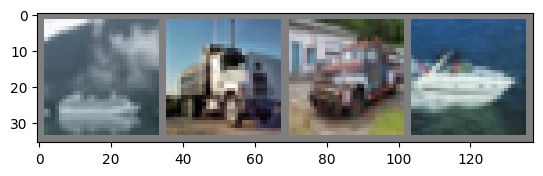

ship  truck truck ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Building the model

We will build the model with Conv2d (Convolutional), ReLU, and Max Pooling layers.

The debugger module (Debugger) has been specially designed to show you the size of the model while training.  

1. The model starts out with [4, 3, 32, 32] which refers to batch size (defined above), color channels, and the width and height of image. Since we are using a color image, there are 3 channels, Red, Green and Blue.  
2. After the Conv2d layer, the width and height are reduced by (kernel_size - 1), which is 4.
3. ReLU does not change the size of the image, and is just an activation function.
4. After MaxPool2d, image size is reduced by 2 since we specified a kernel size of 2 (which means 2x2), and a stride of 2.


Feel free to comment out the line below and re-initialise the model, loss and optimiser to remove the debug statements. We can also see the accuracy at the very bottom of the logs.

In [4]:
class Debugger(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # print("Size:", list(x.shape)) # Comment this line and re-init the model (and loss and optim) to remove the debug statements
        return x

In [5]:
model = nn.Sequential(
    Debugger(),
    nn.Conv2d(3, # input size
              6, # output size
              5), # kernel/filter size
    Debugger(),
    nn.ReLU(),
    nn.Conv2d(6, 16, 5),
    Debugger(),
    nn.ReLU(),
    nn.MaxPool2d(2, # kernel size
                 2), # stride
    Debugger(),
    nn.Flatten(),
    Debugger(),
    nn.Linear(16 * 12 * 12, 800),
    nn.ReLU(),
    nn.Linear(800, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
model.to(device)

Sequential(
  (0): Debugger()
  (1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (2): Debugger()
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Debugger()
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Debugger()
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Debugger()
  (11): Linear(in_features=2304, out_features=800, bias=True)
  (12): ReLU()
  (13): Linear(in_features=800, out_features=120, bias=True)
  (14): ReLU()
  (15): Linear(in_features=120, out_features=84, bias=True)
  (16): ReLU()
  (17): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

# Use Cross Entropy loss
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0035)

## Training the model
We shall train the model over 4 epochs, and for each epoch, we shall:
- Iterate through every entry in the training dataset
- Get a prediction from the model
- Calculate loss
- Backpropagate
- Apply our optimization function
- Print the loss every 2000 entries (in total there is 12500 entries since (train dataset 50000 / batch size 4))

If for some reason your Colab instance cannot connect to a GPU-enabled runtime, this training will run slower; you can reduce epochs of training (`n_epochs`), and try another Google account.

In [7]:
n_epochs = 4
losses =[]
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'epoch, minibatch [{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losses.append(((epoch * 12000 + i), (running_loss / 2000)))
            running_loss = 0.0

print('Finished Training')


epoch, minibatch [1,  2000] loss: 2.301
epoch, minibatch [1,  4000] loss: 2.215
epoch, minibatch [1,  6000] loss: 2.016
epoch, minibatch [1,  8000] loss: 1.882
epoch, minibatch [1, 10000] loss: 1.791
epoch, minibatch [1, 12000] loss: 1.693
epoch, minibatch [2,  2000] loss: 1.614
epoch, minibatch [2,  4000] loss: 1.582
epoch, minibatch [2,  6000] loss: 1.544
epoch, minibatch [2,  8000] loss: 1.502
epoch, minibatch [2, 10000] loss: 1.444
epoch, minibatch [2, 12000] loss: 1.413
epoch, minibatch [3,  2000] loss: 1.362
epoch, minibatch [3,  4000] loss: 1.329
epoch, minibatch [3,  6000] loss: 1.334
epoch, minibatch [3,  8000] loss: 1.320
epoch, minibatch [3, 10000] loss: 1.297
epoch, minibatch [3, 12000] loss: 1.271
epoch, minibatch [4,  2000] loss: 1.171
epoch, minibatch [4,  4000] loss: 1.173
epoch, minibatch [4,  6000] loss: 1.177
epoch, minibatch [4,  8000] loss: 1.163
epoch, minibatch [4, 10000] loss: 1.147
epoch, minibatch [4, 12000] loss: 1.137
Finished Training


In [8]:
import pandas as pd

losses = pd.DataFrame(losses, columns=['minibatch','loss'])

In [9]:
losses['minibatch'] = losses['minibatch'] + 1

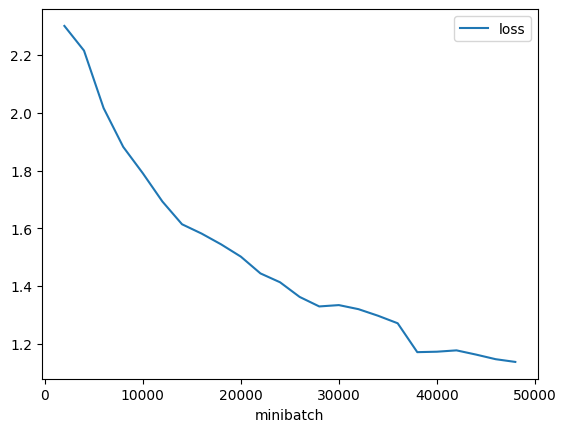

In [10]:
losses.plot.line(x='minibatch',y='loss')
plt.show()

## Evaluation
We shall now perform model evaluation on the data. To do this, we will:
- Iterate through every entry in the testing dataset
- Get a prediction from the model
- Compare this against the correct label/class
- Calculate accuracy (correct / total)

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


## Inference
We can now use the model we have trained to predict the class of an image 🎉  
Let us use testing dataset as the model has not been trained on it before.

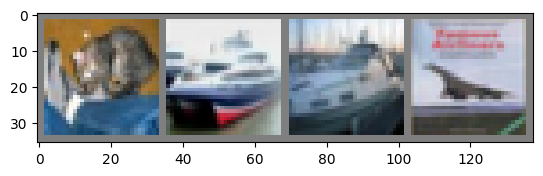

Truth: cat ship ship plane
Prediction: cat ship plane ship


In [12]:
images, labels = next(iter(testloader))
imshow(torchvision.utils.make_grid(images))
print('Truth:', ' '.join(classes[labels[i]] for i in range(batch_size)))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, pred = torch.max(outputs.data, 1)
print("Prediction:", ' '.join(classes[pred[i].item()] for i in range(batch_size)))